In [1]:
import xarray as xr
import xroms
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import pandas as pd

# How to interpolate to one or more points

The process shown here sets up a Delaunay triangulation to convert from longitude/latitude coordinates to grid space (xi_rho/eta_rho). Using this method, curvilinear grids from ROMS can be converted into decoupled horizontal grids. To interpolate in the vertical direction, the `xisoslice` routine is used to determine sigma grid coordinates from desired interpolated depth. Then, `xarray`'s own interpolation schemes can be used.

The necessary routines for interpolating are in `xroms/interp.py`. They have not been generalized much at this point because it looks too complicated to do it correctly, particularly concerning the fact that xarray cannot interpolate in a dimension that is chunked over for using dask. So while the steps necessary to interpolate are clear and are shown below, they haven't been thoroughly automated yet.

### Load in data

More information at in [load_data notebook](load_data.ipynb)

In [2]:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
# chunks = {'ocean_time':1}
# ds = xr.open_dataset(loc, chunks=chunks)

In [3]:
# # set up grid
# proj = cartopy.crs.LambertConformal(central_longitude=-98,    central_latitude=30)
# ds, grid = xroms.roms_dataset(ds, add_verts=True, proj=proj)

### Helpful to have local file for this

In [4]:
url = 'http://barataria.tamu.edu:8080/thredds/fileServer/forecast_latest/txla2_his_a_latest.nc'


In [5]:
# !wget $url

In [6]:
fname = url.split('/')[-1]
chunks = {'ocean_time': 1} #{'s_rho': 1}
ds = xr.open_dataset(fname, chunks=chunks)
# set up grid
proj = cartopy.crs.LambertConformal(central_longitude=-98,    central_latitude=30)
ds, grid = xroms.roms_dataset(ds, add_verts=True, proj=proj)


## Set up

Function `xroms.interp.setup` needs to be run once so that the Delaunay triangulation and functions are calculated and saved. Here, they are saved into a dictionary called `tris` and can subsequently be reused to save time.

In [7]:
# triangulation calculations
tris = xroms.interp.setup(ds)  # setup for all grids

In [8]:
# working toward streamlining connecting grids with variables
vargrid = {}
vargrid['u'] = {'s': 's_rho', 'eta': 'eta_rho', 'xi': 'xi_u', 'grid': 'u', 'z': 'z_rho_u', 'z0': 'z_rho_u0'}
vargrid['v'] = {'s': 's_rho', 'eta': 'eta_v', 'xi': 'xi_rho', 'grid': 'v', 'z': 'z_rho_v', 'z0': 'z_rho_v0'}
vargrid['temp'] = {'s': 's_rho', 'eta': 'eta_rho', 'xi': 'xi_rho', 'grid': 'rho', 'z': 'z_rho', 'z0': 'z_rho0'}
vargrid['salt'] = vargrid['temp']


## Interpolate to...



### times

Interpolating in time is straight-forward because it is 1D, uncoupled from the other dimensions, and there is no necessary mapping between the dimension and coordinate (both of which are just `ocean_time`). So, we can just use the xarray `interp` function directly with the desired times. The result is `[ocean_time x s_rho x eta x xi]`.

The potentially tricky part is that chunking cannot occur in the direction of interpolation. So, here we reset the chunking and chunk in a different dimension before interpolation, then chunk back to `ocean_time` afterward.

In [9]:
# times to interpolate to
startdate = pd.Timestamp(ds.ocean_time[0].values)
t0s = [startdate + pd.Timedelta('30 min')*i for i in range(4)]

# rechunk
ds = ds.chunk(-1).chunk({'s_rho': 1})

# interpolation
ds.interp(ocean_time=t0s).chunk({'ocean_time':1})

<xarray.Dataset>
Dimensions:         (eta_rho: 191, eta_v: 190, eta_vert: 192, ocean_time: 4, s_rho: 30, s_w: 31, tracer: 6, xi_rho: 671, xi_u: 670, xi_vert: 672)
Coordinates:
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lon_u           (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lat_u           (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lon_v           (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lat_v           (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lon_psi         (eta_v, xi_u) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
    lat_psi         (eta_v, xi_u) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
    z_w             (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 191, 671), meta=np.ndarray>
    z_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 191, 670), meta=np.ndarray>
    z_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 190, 671), meta=np.ndarray>
    z_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 31, 190, 670), meta=np.ndarray>
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 1, 191, 671), meta=np.ndarray>
    z_rho_u         (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 191, 670), meta=np.ndarray>
    z_rho_v         (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 190, 671), meta=np.ndarray>
    z_rho_psi       (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 190, 670), meta=np.ndarray>
    z_rho0          (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 191, 671), meta=np.ndarray>
    z_rho_u0        (s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 191, 670), meta=np.ndarray>
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 190, 671), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 190, 670), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 191, 671), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 191, 670), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 190, 671), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 190, 670), meta=np.ndarray>
    lon_vert        (eta_vert, xi_vert) float64 dask.array<chunksize=(192, 672), meta=np.ndarray>
    lat_vert        (eta_vert, xi_vert) float64 dask.array<chunksize=(192, 672), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-...
Dimensions without coordinates: eta_rho, eta_v, eta_vert, tracer, xi_rho, xi_u, xi_vert
Data variables:
    ntimes          int32 4320
    ndtfast         int32 40
    dt              float64 20.0
    dtfast          float64 0.5
    dstart          datetime64[ns] 2018-10-30
    shuffle         int32 1
    deflate         int32 1
    deflate_level   int32 1
    nHIS            int32 180
    ndefHIS         int32 0
    nRST            int32 4320
    nSTA            int32 180
    Falpha          float64 2.0
    Fbeta           float64 4.0
    Fgamma          float64 0.284
    nl_tnu2         (tracer) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    nl_visc2        float64 5.0
    LuvSponge       int32 1
    LtracerSponge   (tracer) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    Akt_bak         (tracer) float64 dask.array<chunksize=(6,), m

### multiple lon, lat locations (1D)

The thing that is tricky about interpolation with a ROMS grid in the xarray environment is that dimensions of xarray DataArrays are indices in grid space, but the grid itself may be curvilinear and is defined in either projected or geographic space. If the grid is curvilinear, it is not directly separable into the grid dimensions `eta` and `xi`. Instead, we have to first interpolate onto grid space to calculate the `eta` and `xi` coordinates that match desired longitude/latitude coordinate pairs. Once we know the desired grid space coordinates, it is easy to [interpolate in xarray](http://xarray.pydata.org/en/stable/interpolation.html) using the familiar `isel`- and `sel`-style syntax but with `interp` instead.

Interpolate salinity to points defined in lon/lat; preserve input times and water columns. Result is `[ocean_time x s_rho x pts]`. Reduce the number of sigma levels or times included in the result by selecting before or after the interpolation call.

If the surface sigma level and all times are selected, this could be useful for interpolation to buoy locations.

In [10]:
# want salt at the following coords
lon0, lat0 = [-96, -96,-91.5,-93], [24, 28,29.2,28]
varin = ds.salt

# lazily do the interpolation
var = xroms.interp.interp(varin, tris[vargrid[varin.name]['grid']], lon0, lat0)
print(var)

<xarray.DataArray 'salt' (ocean_time: 24, s_rho: 30, pts: 4)>
dask.array<_interpnd, shape=(24, 30, 4), dtype=float32, chunksize=(24, 1, 4), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (pts) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    lat_rho     (pts) float64 dask.array<chunksize=(4,), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
    z_rho       (ocean_time, s_rho, pts) float64 dask.array<chunksize=(24, 1, 4), meta=np.ndarray>
    z_rho0      (s_rho, pts) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    xi_rho      (pts) float64 31.29 198.6 439.3 341.8
    eta_rho     (pts) float64 24.18 116.5 121.4 29.63
Dimensions without coordinates: pts
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series


Note that you can retrieve grid information about the interpolation points from the object DataArray:

    var.ocean_time, var.eta_rho, var.xi_rho

Plot the interpolated salinity overlaid on the full field to visually check.

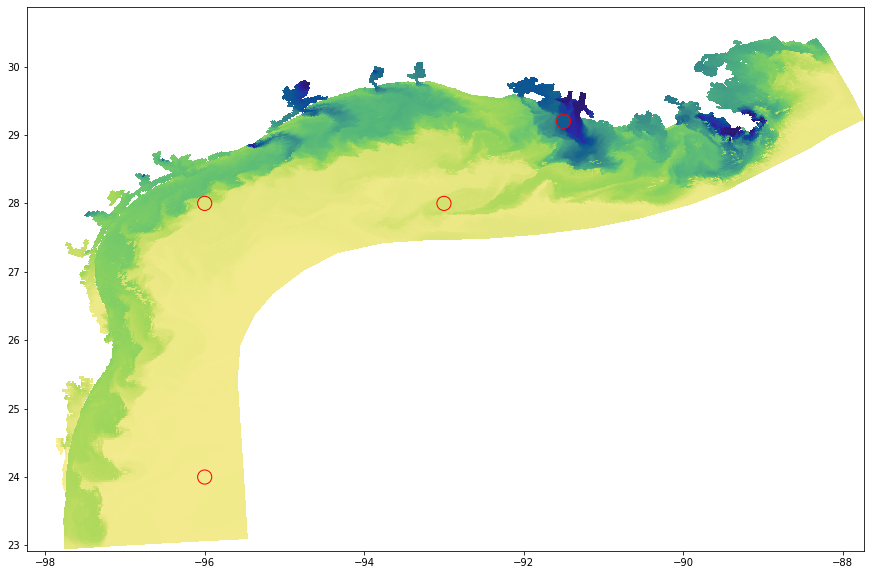

In [11]:
indexer = {'ocean_time': 0, 's_rho': -1}
salt = ds.salt.isel(indexer)
vmin = salt.min().values; vmax = salt.max().values

fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.pcolormesh(ds.lon_vert, ds.lat_vert, salt, cmap=cmo.haline)  # full field
ax.scatter(lon0, lat0, c=var.isel(indexer), s=200, edgecolor='r', vmin=vmin, vmax=vmax, cmap=cmo.haline)

### array of grid nodes (2D) regridded to several water depths

Select v velocity for the full horizontal grid, then interpolate to z and preserve time.

This is a way to convert model output from sigma to fixed z depths. For this, we can directly used the function `calc_zslices` that is used in `interp`.

In [14]:
z0s = [-20,-10]
varin = ds.v

sl = xroms.interp.calc_zslices(varin, z0s, zetaconstant=True)
print(sl)

<xarray.DataArray (z: 2, ocean_time: 24, eta_v: 190, xi_rho: 671)>
dask.array<concatenate, shape=(2, 24, 190, 671), dtype=float64, chunksize=(1, 24, 190, 671), chunktype=numpy.ndarray>
Coordinates:
    lat_v       (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
  * z           (z) int64 -20 -10
Dimensions without coordinates: eta_v, xi_rho


### array of lon, lat locations (2D)

Interpolate u velocity to an array of lon/lat points; preserve input times and water columns. Result is [ocean_time x s_rho x eta_pts x xi_pts].

This could be useful for interpolating to an HF Radar field if just the surface is selected.

In [16]:
# want salt at the following coords
npts = 5
lon0, lat0 = np.linspace(-96, -95,npts), np.linspace(27,28,npts+1)
LON0, LAT0 = np.meshgrid(lon0, lat0)
varin = ds.u

# lazily do the interpolation
var = xroms.interp.interp(varin, tris[vargrid[varin.name]['grid']], LON0, LAT0)
print(var)

<xarray.DataArray 'u' (ocean_time: 24, s_rho: 30, eta_pts: 6, xi_pts: 5)>
dask.array<_interpnd, shape=(24, 30, 6, 5), dtype=float32, chunksize=(24, 1, 6, 5), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_u       (eta_pts, xi_pts) float64 dask.array<chunksize=(6, 5), meta=np.ndarray>
    lat_u       (eta_pts, xi_pts) float64 dask.array<chunksize=(6, 5), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
    z_rho_u     (ocean_time, s_rho, eta_pts, xi_pts) float64 dask.array<chunksize=(24, 1, 6, 5), meta=np.ndarray>
    z_rho_u0    (s_rho, eta_pts, xi_pts) float64 dask.array<chunksize=(1, 6, 5), meta=np.ndarray>
    xi_u        (eta_pts, xi_pts) float64 161.6 168.3 176.0 ... 223.4 233.6
    eta_rho     (eta_pts, xi_pts) float64 60.65 46.3 32.9 ... 90.48 79.1 68.96
Dimensions without coordinates: eta_pts, xi_pts
Attributes:
    long_name:  u-momentum component
    units:  

### multiple z, y, x locations

Interpolate temperature to several specific (z,y,x) locations and include all available times. The result is [ocean_time x pts]. Note that inputting the flag `zetaconstant=True` will speed up the calculation by calculating the depth only once and with respect to mean sea level instead of allowing zeta to vary with time in the calculation.

This could be useful for interpolating to match several data stations that are not at the surface.

In [17]:
# %%timeit
lon0, lat0, z0s = [-96, -96,-91.5,-93], [24, 28,29.2,28], [-10, -50, -40, -20]
varin = ds.temp.isel(ocean_time=slice(0,3))

var3 = xroms.interp.interp(varin, tris[vargrid[varin.name]['grid']], lon0, lat0, z0s, zetaconstant=True, triplets=True)
print(var3.transpose('ocean_time','pts'))

<xarray.DataArray (ocean_time: 3, pts: 4)>
dask.array<transpose, shape=(3, 4), dtype=float64, chunksize=(3, 4), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (pts) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    lon_rho     (pts) float64 dask.array<chunksize=(4,), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-3...
    z           (pts) int64 -10 -50 -40 -20
    xi_rho      (pts) float64 31.29 198.6 439.3 341.8
    eta_rho     (pts) float64 24.18 116.5 121.4 29.63
Dimensions without coordinates: pts


### multiple t, z, y, x locations

To interpolate in time in addition to z,y,x (previous example), we can simply interpolate in time after interpolating in the other dimensions first. Additional complexity can come if chunking is in the `ocean_time` dimension, in which case the chunking first has to change before interpolation. (The same is true before interpolation in any dimension, but the example on this page is read in with chunking only in `ocean_time`.)

This approach could be used for interpolating model output to compare directly with glider or ship tracks.

In [19]:
lon0, lat0, z0s = [-96, -96,-91.5,-93], [24, 28,29.2,28], [-10, -50, -40, -20]
varin = ds.temp.isel(ocean_time=slice(0,3))

var3 = xroms.interp.interp(varin, tris[vargrid[varin.name]['grid']], lon0, lat0, z0s, zetaconstant=True, triplets=True)
var3 = var3.transpose('ocean_time','pts')

# times to interpolate to
startdate = pd.Timestamp(ds.ocean_time[0].values)
t0s = [startdate + pd.Timedelta('30 min')*i for i in range(3)]

# rechunk
var3 = var3.chunk(-1).chunk({'pts': 1})

# interpolation
print(var3.interp(ocean_time=t0s).chunk({'ocean_time':1}))

<xarray.DataArray (ocean_time: 3, pts: 4)>
dask.array<rechunk-merge, shape=(3, 4), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (pts) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lon_rho     (pts) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z           (pts) int64 -10 -50 -40 -20
    xi_rho      (pts) float64 31.29 198.6 439.3 341.8
    eta_rho     (pts) float64 24.18 116.5 121.4 29.63
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-3...
Dimensions without coordinates: pts


### Cross-section

A cross-section can be calculated using `xisoslice` from `xroms`. A short example will be given here, but more details are available in the [select_data notebook](select_data.ipynb). 3D interpolation in this notebook uses `xisoslice` to calculate `s_rho` indices.

Calculate cross-section of u-velocity along latitude of 27 degrees.

In [21]:
lat0 = 27
varin = ds.u

sl = xroms.xisoslice(varin['lat_u'], lat0, varin, vargrid[varin.name]['eta'])

print(sl)

<xarray.DataArray (ocean_time: 24, s_rho: 30, xi_u: 670)>
dask.array<sub, shape=(24, 30, 670), dtype=float64, chunksize=(24, 1, 670), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
Dimensions without coordinates: xi_u


## Examples of timing

Make table of timing examples from above for local file.

# To dos

* make sigma coordiante changable to w from rho as needed
* try accessor when this is more stable
* more plot examples
* are dims name what I want?
* diagnostic variable
* fill out timings

* maybe make xroms.interp an accessor and shift things into there. first need to save to github as a draft that works.

plot a water column and a time series to show they match

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


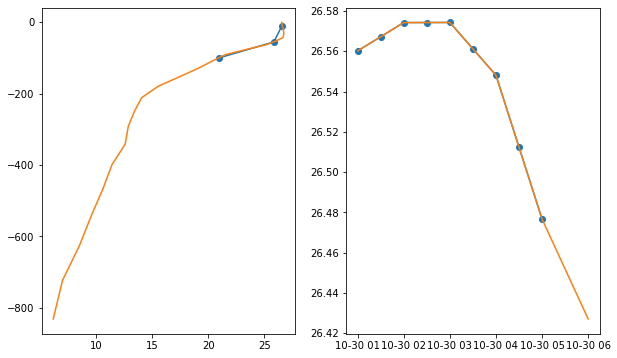

In [229]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

# demonstrate result for 1 water column calculation
varp = var.isel(ocean_time=0, pts=0)
# compare with neighboring point
xi0, eta0 = xroms.ll2xe(tris['rho'], lon0, lat0)
dss = ds.temp.isel(ocean_time=0, xi_rho=int(xi0[0]), eta_rho=int(eta0[0]))

axes[0].plot(varp, varp.z, marker='o')
axes[0].plot(dss, dss.z_rho)


# demonstrate 1 time series
vart = var2.isel(pts=0, z=0)
# compare with un-interpolated output
varo = var.isel(pts=0, z=0, ocean_time=slice(0,6))

axes[1].plot(vart.ocean_time, vart, marker='o')
axes[1].plot(varo.ocean_time, varo)


Try a glider track with interp(). These are assumed to be independent points.

OUTCOME: a "glider" track with 15 independent points took an average of 57 sec using `interp` and an average of 8 seconds using `interp_triplet`. 

QUESTION: where does it switch over between functions? Design a couple of test cases.

In [232]:
z0s = np.linspace(-10,-100,3)
npt = 5
lon0, lat0 = np.linspace(-96,-93,npt), np.linspace(26,28, npt)
lon0, lat0, z0s = np.array(list(lon0)*3), np.array(list(lat0)*3), z0s.repeat(5)
startdate = pd.Timestamp(ds.ocean_time[0].values)
t0s = [startdate + pd.Timedelta('30 min')*i for i in range(lon0.size)]
varin = ds.temp
# lon0, lat0, z0s, t0s

In [243]:
%%timeit
# interpolate in the dimensions that are not chunked over
var = xroms.interp.interp(varin, tris[vargrid[varin.name]['grid']], lon0, lat0, z0s)
var = var.transpose('ocean_time','z','pts')

# rechunk so that remaining dimension is not chunked over
var = var.chunk({'ocean_time':-1, 'z': -1, 'pts': -1})  # reset chunks to 1 
var = var.chunk({'z': 1})  # chunk over z now

# perform final interpolation
var2 = var.interp(ocean_time=t0s)

# if these are triplets, need to additionally index

t0s2 = xr.DataArray(np.arange(len(lon0)), dims="pts2")
pts2 = xr.DataArray(np.arange(len(lon0)), dims="pts2")
z0s2 = xr.DataArray(np.arange(len(lon0)), dims="pts2")
var2out = var2.isel(ocean_time=t0s2, pts=pts2, z=z0s2)  # isel bc selecting from interpolated object
var2out.values

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/o

57.1 s ± 2.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [239]:
var2out.values

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array([26.56015104, 27.56057679, 27.97493488, 27.32446511, 26.10407959,
       25.9256817 , 26.20707693, 26.25316408, 25.24948635, 26.89895465,
       20.73039324, 20.64716813, 20.08210293, 21.09257294, 21.11204811])

Compare this with triplet approach

In [242]:
%%timeit
varout = interp_triplet(varin, tris['rho'], lon0, lat0, z0s, t0s)
varout.values

8.41 s ± 284 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [241]:
varout.values

array([26.56002187, 27.56057655, 27.97493309, 27.32447888, 26.10444662,
       25.9256499 , 26.20708815, 26.25310565, 25.24760676, 26.87281392,
       20.73790901, 20.64716773, 20.08196945, 21.09215332, 21.15336571])

 Interpolate to z grid for 1 time

In [280]:
# for interp:
z0s = np.linspace(-10,-100,3)
npt = 5
lon0, lat0 = np.linspace(-96,-93,npt), np.linspace(26,28, npt)

# as triplets:
LON0, Z0s = np.meshgrid(lon0, z0s)
LAT0, _ = np.meshgrid(lat0, z0s)
LON0, LAT0, Z0s = LON0.flatten(), LAT0.flatten(), Z0s.flatten()

varin = ds.temp.isel(ocean_time=0)

Interp()

In [250]:
%%timeit
# interp()

# interpolate in the dimensions that are not chunked over
var = xroms.interp.interp(varin, tris[vargrid[varin.name]['grid']], lon0, lat0, z0s)

var.values

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/o

1.29 s ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


## Get grid indices out

They are stored in an interpolated DataArray.

Note that:
* `eta` and `xi` grid indices do not change in time and thus can be reused, but are different for different grids.
* if flag `zetaconstant=True` is used, then changes in zeta in time are not considered when calculating sigma grid indices and therefore are not dependent on time, in which case they also can be reused for a given (z,y,x) triplet. However, if time is being considered such that z is time-varying, then a given sigma grid index is specific to the t,z,y,x 4D time/location.